# Temporal & Spatial Auto-Correlation

In [1]:
%%time

import os
os.environ["USE_PYGEOS"] = "0"
import sys
import gc
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from libpysal.weights import KNN, Queen, Rook, DistanceBand
from esda.moran import Moran, Moran_Local
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm.notebook import tqdm
import joblib
from joblib import Parallel, delayed
import time
import json

CPU times: user 1.86 s, sys: 609 ms, total: 2.47 s
Wall time: 1.84 s


In [2]:
%%time

# Load dataset
df = pd.read_csv("data/data.csv")

# Drop the 'id' and 'dropoff_datetime' column if it exists
df = df.drop(columns=["id", "dropoff_datetime"], errors="ignore")

# Create a new column with log-transformed trip duration
df["log_trip_duration"] = np.log1p(df["trip_duration"])  # log(x + 1) to handle zero values
target_cols = ["trip_duration", "log_trip_duration"]

# Convert 'pickup_datetime' and 'dropoff_datetime' to datetime format
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])

# Adjust 'vendor_id' (convert from {1,2} to {0,1})
df["vendor_id"] = df["vendor_id"] - 1

# Convert 'store_and_fwd_flag' to binary (0 = True, 1 = False)
df["store_and_fwd_flag"] = df["store_and_fwd_flag"].map({"Y": 0, "N": 1})

# Display the first few rows to verify changes
print(df.head())

   vendor_id     pickup_datetime  passenger_count  pickup_longitude  \
0          1 2016-03-14 17:24:55                1        -73.982155   
1          0 2016-06-12 00:43:35                1        -73.980415   
2          1 2016-01-19 11:35:24                1        -73.979027   
3          1 2016-04-06 19:32:31                1        -74.010040   
4          1 2016-03-26 13:30:55                1        -73.973053   

   pickup_latitude  dropoff_longitude  dropoff_latitude  store_and_fwd_flag  \
0        40.767937         -73.964630         40.765602                   1   
1        40.738564         -73.999481         40.731152                   1   
2        40.763939         -74.005333         40.710087                   1   
3        40.719971         -74.012268         40.706718                   1   
4        40.793209         -73.972923         40.782520                   1   

   trip_duration  log_trip_duration  
0            455           6.122493  
1            663      

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   vendor_id           1458644 non-null  int64         
 1   pickup_datetime     1458644 non-null  datetime64[ns]
 2   passenger_count     1458644 non-null  int64         
 3   pickup_longitude    1458644 non-null  float64       
 4   pickup_latitude     1458644 non-null  float64       
 5   dropoff_longitude   1458644 non-null  float64       
 6   dropoff_latitude    1458644 non-null  float64       
 7   store_and_fwd_flag  1458644 non-null  int64         
 8   trip_duration       1458644 non-null  int64         
 9   log_trip_duration   1458644 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(4)
memory usage: 111.3 MB


In [4]:
df.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration
0,1,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,1,455,6.122493
1,0,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,1,663,6.498282
2,1,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,1,2124,7.661527
3,1,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,1,429,6.063785
4,1,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,1,435,6.077642


## General Autocorrelation

In [5]:
%%time

# Compute and print PMCC for each target column
for target_col in target_cols:
    correlations = df.corr(method="pearson")[target_col].drop(target_cols)
    
    print(f"\nPearson Correlation Coefficients with '{target_col}':")
    print(correlations)


Pearson Correlation Coefficients with 'trip_duration':
vendor_id             0.020304
pickup_datetime       0.006644
passenger_count       0.008471
pickup_longitude      0.026542
pickup_latitude      -0.029204
dropoff_longitude     0.014678
dropoff_latitude     -0.020677
store_and_fwd_flag   -0.001724
Name: trip_duration, dtype: float64

Pearson Correlation Coefficients with 'log_trip_duration':
vendor_id             0.019720
pickup_datetime       0.048036
passenger_count       0.021044
pickup_longitude      0.110991
pickup_latitude      -0.144853
dropoff_longitude     0.071901
dropoff_latitude     -0.123888
store_and_fwd_flag   -0.015326
Name: log_trip_duration, dtype: float64
CPU times: user 749 ms, sys: 128 ms, total: 877 ms
Wall time: 874 ms


## Temporal Autocorrelation

In [6]:
%%time

df.set_index("pickup_datetime", inplace=True)
df.sort_index(inplace=True)

CPU times: user 351 ms, sys: 50.6 ms, total: 401 ms
Wall time: 399 ms


In [7]:
%%time

# Resample
resampled_data_hourly = df.resample("H").mean().fillna(0)   # Every 1 Hour
resampled_data_3hour = df.resample("3H").mean().fillna(0)   # Every 3 Hour
resampled_data_daily = df.resample("D").mean().fillna(0)    # Every Day
resampled_data_weekly = df.resample("W").mean().fillna(0)   # Every Week

CPU times: user 480 ms, sys: 593 ms, total: 1.07 s
Wall time: 1.07 s


In [8]:
%%time

def plot_acf_pacf(df, col_name, save_name=None, general_title=None):
    """
    Plots and saves the ACF and PACF of the specified column in the dataframe.

    Parameters:
    df (pd.DataFrame): Dataframe containing the data.
    col_name (str): The column name to plot the ACF and PACF for.
    save_name (str): The filename (without path) to save the resulting PNG file. 
                     If None, uses the column name as default.
    general_title (str): A general title for the entire figure. If None, no title is added.
    """
    # Create the 'images' directory if it doesn't exist
    if not os.path.exists("images"):
        os.makedirs("images")

    # Set the default save name if not provided
    if save_name is None:
        save_name = f"acf-pacf-{col_name}.png"
        
    # Convert Col Names into Titles
    if col_name == "trip_duration":
        col_title = "Trip Duration"
    elif col_name == "log_trip_duration":
        col_title = "Log-Transformed Trip Duration"
    else:
        raise ValueError("col_name not handled!")

    # Set the full save path in the images folder
    save_path = os.path.join("images", save_name)

    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    plot_acf(df[col_name], ax=axes[0], title=f"ACF of {col_title}")
    plot_pacf(df[col_name], ax=axes[1], title=f"PACF of {col_title}")

    # Adding labels to the ACF and PACF
    axes[0].set_xlabel("Lag")
    axes[0].set_ylabel("ACF")
    axes[1].set_xlabel("Lag")
    axes[1].set_ylabel("PACF")
    
    # Adding a general title if passed
    if general_title:
        fig.suptitle(general_title, fontsize=16)

    fig.tight_layout()
    plt.savefig(save_path, dpi=300,  bbox_inches='tight')
    plt.show()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 16.2 µs


Drawing acf-pacf-Hourly-trip_duration.png...


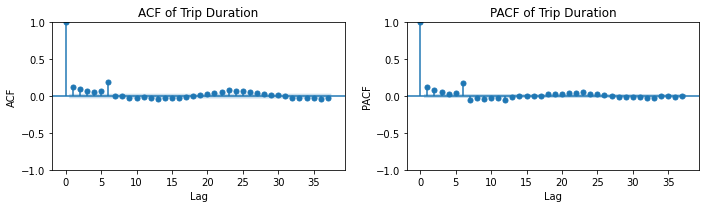

Drawing acf-pacf-Hourly-log_trip_duration.png...


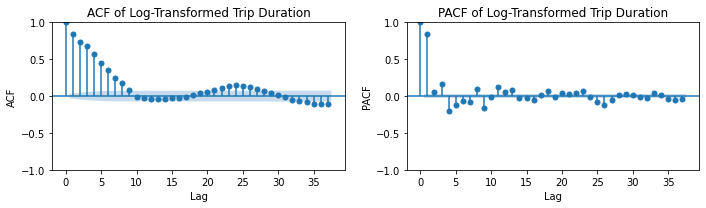

Drawing acf-pacf-3-Hourly-trip_duration.png...


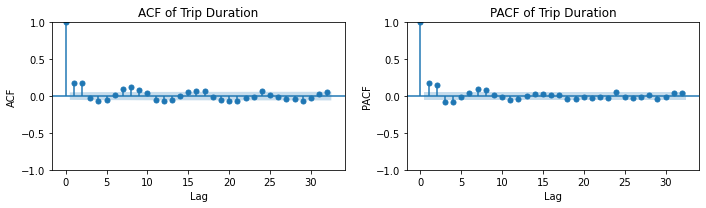

Drawing acf-pacf-3-Hourly-log_trip_duration.png...


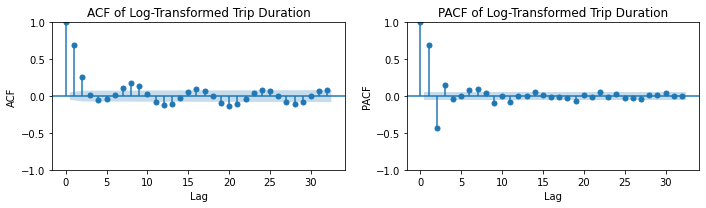

Drawing acf-pacf-Daily-trip_duration.png...


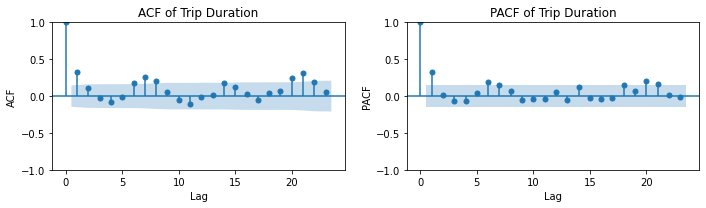

Drawing acf-pacf-Daily-log_trip_duration.png...


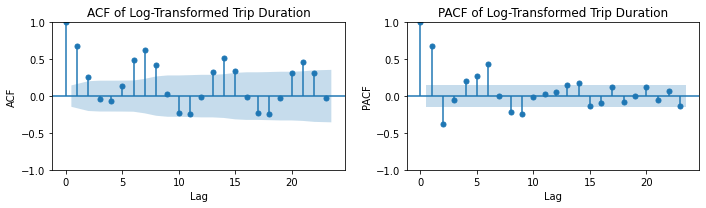

Drawing acf-pacf-Weekly-trip_duration.png...


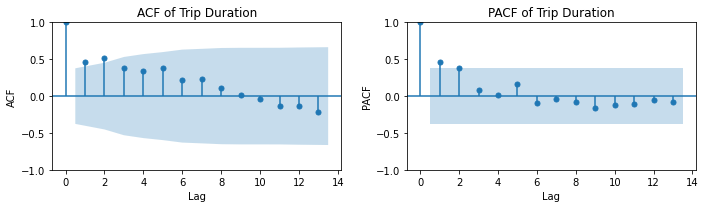

Drawing acf-pacf-Weekly-log_trip_duration.png...


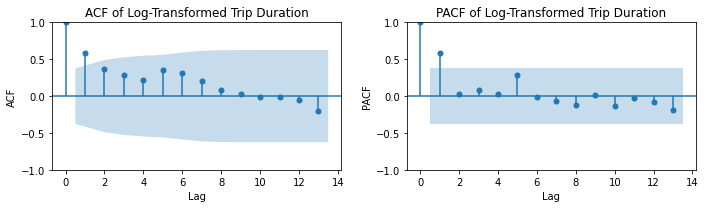

CPU times: user 7.33 s, sys: 3.7 s, total: 11 s
Wall time: 3.71 s


In [9]:
%%time

# List of resampled dataframes
resampled_datasets = {
    "Hourly": resampled_data_hourly,
    "3-Hourly": resampled_data_3hour,
    "Daily": resampled_data_daily,
    "Weekly": resampled_data_weekly
}

# List of columns to plot
columns_to_plot = ["trip_duration", "log_trip_duration"]

# Set global font size for all plot elements
plt.rcParams.update({'font.size': 14})  # Update all font sizes to 14

# Loop through each resampled dataset and column
for resample_name, resampled_df in resampled_datasets.items():
    for col_name in columns_to_plot:
        save_name = f"acf-pacf-{resample_name}-{col_name}.png"
        
        # Create the general title
        if col_name == "log_trip_duration":
            general_title = f"ACF and PACF for Logged Trip Duration for {resample_name.capitalize()} Resampled Data"
        else:
            general_title = f"ACF and PACF for Trip Duration for {resample_name.capitalize()} Resampled Data"

        print(f"Drawing {save_name}...")
        plot_acf_pacf(resampled_df, col_name, save_name, general_title=None)
        
        
# Reset global font size for all plot elements
plt.rcParams.update({'font.size': 12})  # Update all font sizes to 12

The ACF and PACF of the original trip duration exhibit similar patterns to those of the log-transformed version, though they are less pronounced. In contrast, the log-transformed trip duration shows clearer periodicity, particularly in hourly, 3-hourly, and daily resampling, indicating a periodic component. The log-transformed data reveals a strong positive correlation at lag 1, with correlations gradually decreasing at subsequent lags. This suggests significant short-term dependence, extending beyond the 95% confidence interval with high correlation values, however, as the lag increases, the correlation approaches zero, indicating negligible long-term dependencies. In weekly resampling, fewer correlations fall outside the confidence interval, demonstrating a weakening trend and insignificant autocorrelation. Overall, the log-transformed trip duration displays more pronounced temporal patterns than the original version.

## Spatial Autocorrelation

In [10]:
%%time

def filter_by_nyc_boundary(df, geojson_path):
    """
    Filters pickup and dropoff locations to keep only those within the New York City boundary.

    Parameters:
        df (pd.DataFrame): The DataFrame containing pickup and dropoff coordinates.
        geojson_path (str): Path to the GeoJSON file defining NYC boundaries.

    Returns:
        pd.DataFrame: Filtered DataFrame with locations inside the NYC bounding box.
    """
    # Load the GeoJSON file
    with open(geojson_path, "r") as f:
        geojson_data = json.load(f)

    # Extract NYC boundary coordinates where NAME is "New York"
    nyc_coords = []
    for feature in geojson_data["features"]:
        if feature["properties"].get("NAME") == "New York":
            for polygon in feature["geometry"]["coordinates"]:  # Loop through MultiPolygon
                for ring in polygon:  # Each polygon has a ring of coordinates
                    nyc_coords.extend(ring)

    # Compute NYC bounding box (min/max latitudes & longitudes)
    min_long = min(lon for lon, lat in nyc_coords)
    max_long = max(lon for lon, lat in nyc_coords)
    min_lat = min(lat for lon, lat in nyc_coords)
    max_lat = max(lat for lon, lat in nyc_coords)

    # Count records before filtering
    initial_count = len(df)

    # Filter data based on bounding box
    mask = (
        (df["pickup_longitude"].between(min_long, max_long))
        & (df["pickup_latitude"].between(min_lat, max_lat))
        & (df["dropoff_longitude"].between(min_long, max_long))
        & (df["dropoff_latitude"].between(min_lat, max_lat))
    )

    filtered_df = df[mask]

    # Count records after filtering
    final_count = len(filtered_df)
    dropped_count = initial_count - final_count

    print(f"Records before filtering: {initial_count}")
    print(f"Records after filtering: {final_count}")
    print(f"Records dropped: {dropped_count}\n")

    return filtered_df


# Apply function to df
df = filter_by_nyc_boundary(df, "utils/gz_2010_us_040_00_5m.json")

Records before filtering: 1458644
Records after filtering: 1458577
Records dropped: 67

CPU times: user 210 ms, sys: 44.9 ms, total: 255 ms
Wall time: 251 ms


In [11]:
%%time

# Ensure the index is numeric
df_copy = df.reset_index(drop=True).copy()

# Select only the required columns
df_copy = df_copy[["pickup_longitude", "pickup_latitude",
                   "dropoff_longitude", "dropoff_latitude",
                   "log_trip_duration", "trip_duration"]]

# Display the first few rows of the new DataFrame
df_copy.head()

CPU times: user 93.2 ms, sys: 200 ms, total: 294 ms
Wall time: 291 ms


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,log_trip_duration,trip_duration
0,-73.981743,40.719158,-73.938828,40.829182,6.745236,849
1,-73.985085,40.747166,-73.958038,40.717491,7.166266,1294
2,-73.965279,40.801041,-73.947479,40.815170,6.013715,408
3,-73.982292,40.751331,-73.991341,40.750340,5.638355,280
4,-73.970108,40.759800,-73.989357,40.742989,6.602588,736


In [12]:
%%time

# Function to create grid and calculate mean of the target column
def create_grid_with_mean(gdf, lat_col, lon_col, target_col1, target_col2):
    # Round latitude and longitude to 3 decimal places
    gdf["lat_bin"] = gdf[lat_col].round(2)
    gdf["lon_bin"] = gdf[lon_col].round(2)
    
    print(gdf.head(20))
    
    # Precompute mean values for each lat_bin and lon_bin combination
    means = gdf.groupby(["lat_bin", "lon_bin"]).agg(
        mean_log_trip_duration=(target_col1, "mean"),
        mean_trip_duration=(target_col2, "mean")
    ).reset_index()
    
    # Fill NaN values with 1e-5 for missing data points
    means["mean_log_trip_duration"].fillna(1e-5, inplace=True)
    means["mean_trip_duration"].fillna(1e-5, inplace=True)
    
    # Convert to GeoDataFrame
    grid_gdf = gpd.GeoDataFrame(
        means, 
        geometry=gpd.points_from_xy(means["lon_bin"], means["lat_bin"]), 
        crs="EPSG:4326"
    )

    return grid_gdf

# Create grid with mean values for pickup and dropoff
print("Processing grid_gdf_pickup...")
grid_gdf_pickup = create_grid_with_mean(df_copy, "pickup_latitude", "pickup_longitude", "log_trip_duration", "trip_duration")
print("Processing grid_gdf_dropoff...")
grid_gdf_dropoff = create_grid_with_mean(df_copy, "dropoff_latitude", "dropoff_longitude", "log_trip_duration", "trip_duration")

Processing grid_gdf_pickup...
    pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0         -73.981743        40.719158         -73.938828         40.829182   
1         -73.985085        40.747166         -73.958038         40.717491   
2         -73.965279        40.801041         -73.947479         40.815170   
3         -73.982292        40.751331         -73.991341         40.750340   
4         -73.970108        40.759800         -73.989357         40.742989   
5         -73.984993        40.773891         -73.936493         40.847771   
6         -73.973335        40.764072         -73.974854         40.761734   
7         -73.993103        40.752632         -73.953903         40.816540   
8         -73.985443        40.735710         -73.957489         40.811611   
9         -73.993736        40.741760         -74.004669         40.745468   
10        -73.976860        40.683376         -73.983643         40.688866   
11        -74.006439        40.739

In [13]:
%%time

# Define colormap dictionary
coolwarm_cmap = sns.color_palette("coolwarm", 5)

cluster_colors = {
    "Not Significant": coolwarm_cmap[2], # Grey for non-significant values
    "HH (Hot Spot)": coolwarm_cmap[4],  # Red for hot spots
    "LL (Cold Spot)": coolwarm_cmap[0],  # Blue for cold spots
    "LH (Spatial Outlier)": coolwarm_cmap[1],  # Light blue
    "HL (Spatial Outlier)": coolwarm_cmap[3],  # Light red
}

# Define the order of clusters for plotting
order = [
    "HL (Spatial Outlier)",  # Color 3 (light red) at the bottom
    "Not Significant",       # Color 2 (grey)
    "LH (Spatial Outlier)",  # Color 1 (light blue)
    "LL (Cold Spot)",        # Color 0 (blue)
    "HH (Hot Spot)",         # Color 4 (red)
]

# Global Moran’s I Test
def morans_i_test(gdf, target_col, w, verbose=False):
    moran = Moran(gdf[target_col].values, w)
    if verbose:
        print(f"Moran's I: {moran.I}, p-value: {moran.p_norm}")
    return moran.I, moran.p_norm

# Local Moran’s I (Hotspot Analysis)
def local_morans_i(gdf, target_col, w):
    moran_loc = Moran_Local(gdf[target_col].values, w)
    gdf["Moran_I"] = moran_loc.Is
    gdf["p_value"] = moran_loc.p_sim
    
    # Identify significant clusters
    gdf["cluster"] = "Not Significant"
    gdf.loc[(moran_loc.q == 1) & (gdf["p_value"] < 0.05), "cluster"] = "HH (Hot Spot)"
    gdf.loc[(moran_loc.q == 3) & (gdf["p_value"] < 0.05), "cluster"] = "LL (Cold Spot)"
    gdf.loc[(moran_loc.q == 2) & (gdf["p_value"] < 0.05), "cluster"] = "LH (Spatial Outlier)"
    gdf.loc[(moran_loc.q == 4) & (gdf["p_value"] < 0.05), "cluster"] = "HL (Spatial Outlier)"
    
    return gdf

# Visualize Moran’s I Clusters and Save the Plot
def plot_morans_clusters(gdf, location_type, tgt_col, xlim=[-74.75, -73.0], ylim=[40.4, 41.25]):
    """
    Plots the Local Moran's I clusters and saves the plot as a PNG file with 300 dpi.
    
    Parameters:
    gdf (GeoDataFrame): GeoDataFrame containing the clusters.
    location_type (str): Either 'pickup' or 'dropoff' to specify the location type.
    tgt_col (str): Either 'mean_trip_duration' or 'mean_log_trip_duration' to specify the target type.
    xlim (list): X-axis limits [min, max].
    ylim (list): Y-axis limits [min, max].
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    if tgt_col == "mean_trip_duration":
        target_type = "Trip Duration"
    elif tgt_col == "mean_log_trip_duration":
        target_type = "Logged Trip Duration"
    else:
        raise ValueError("`target_type` not handled!")
    
    # Assign colors based on cluster classification
    gdf["color"] = gdf["cluster"].map(cluster_colors)
    
    # Reorder the GeoDataFrame
    gdf = gdf.set_index("cluster").loc[order].reset_index()
    
    gdf.plot(color=gdf["color"], alpha=0.6,
             markersize=50, legend=True, ax=ax)
    
    # Create legend handles
    legend_handles = [mpatches.Patch(color=cluster_colors[cluster], label=cluster) for cluster in cluster_colors]
    
    # Set limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Title and filename based on method and location_type (pickup or dropoff)
    title = f"Local Moran's I Clusters ({location_type.capitalize()} Loc & {target_type})"
    filename = f"images/morans_clusters_{location_type.lower()}_{target_type}.png"
    
    # Set plot title and add legend
    plt.title(title)
    ax.legend(handles=legend_handles, loc="lower right", fontsize="small", labelspacing=0.25)
    
    # Save and show the plot
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()  # Close to free memory

CPU times: user 0 ns, sys: 1.41 ms, total: 1.41 ms
Wall time: 1.29 ms


Compute Global Moran's I
Compute Local Moran's I
Draw and save Local Moran's I clusters


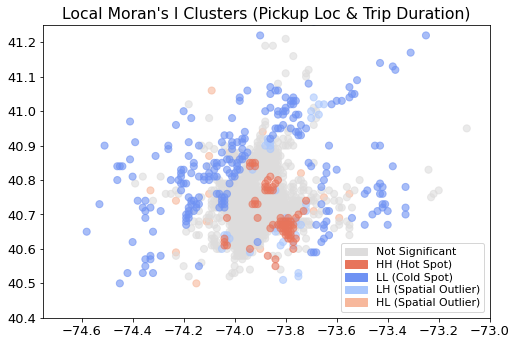

{'dataset': 'pickup', 'moran_i': 0.1676, 'p_value_global': 0.0}
Compute Global Moran's I
Compute Local Moran's I
Draw and save Local Moran's I clusters


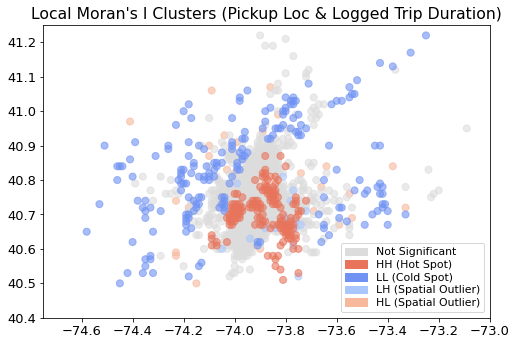

{'dataset': 'pickup', 'moran_i': 0.4857, 'p_value_global': 0.0}
Compute Global Moran's I
Compute Local Moran's I
Draw and save Local Moran's I clusters


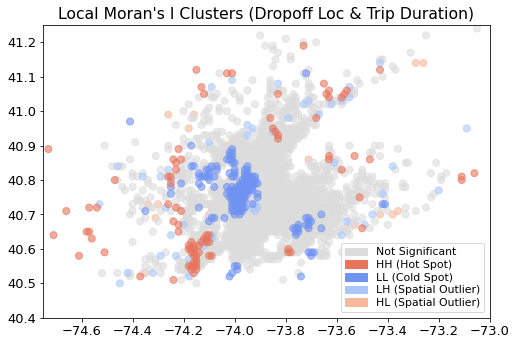

{'dataset': 'dropoff', 'moran_i': 0.0452, 'p_value_global': 0.0008}
Compute Global Moran's I
Compute Local Moran's I
Draw and save Local Moran's I clusters


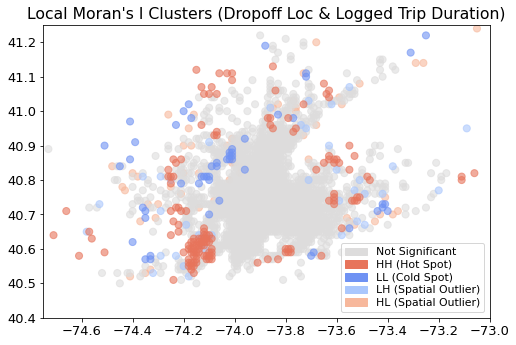

{'dataset': 'dropoff', 'moran_i': 0.1051, 'p_value_global': 0.0}
CPU times: user 8.1 s, sys: 1.74 s, total: 9.84 s
Wall time: 8.08 s


{'dataset': 'dropoff', 'moran_i': 0.1051, 'p_value_global': 0.0}

In [14]:
%%time

# Set global font size for all plot elements
plt.rcParams.update({'font.size': 13})  # Update all font sizes to 13

# Function to process a single method-dataset combination
def process_method(gdf_name, gdf, tgt_col):    
    # Compute spatial weights
    # Example coordinates (replace with your actual gdf's geometry)
    coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))
    w = KNN.from_array(coords, k=5)  # 5 nearest neighbors
        
    # Compute Global Moran's I
    print("Compute Global Moran's I")
    moran_i, p_value_global = morans_i_test(gdf, tgt_col, w)
        
    # Compute Local Moran's I
    print("Compute Local Moran's I")
    local_moran_gdf = local_morans_i(gdf, tgt_col, w)
        
    # Draw and save Local Moran's I clusters
    print("Draw and save Local Moran's I clusters")
    plot_morans_clusters(gdf, gdf_name, tgt_col)
        
    # Generate results
    result = {
        "dataset": gdf_name,
        "moran_i": round(moran_i, 4),
        "p_value_global": round(p_value_global, 4),
        }
    print(result)
    
    return result
    
process_method("pickup", grid_gdf_pickup, tgt_col="mean_trip_duration")
process_method("pickup", grid_gdf_pickup, tgt_col="mean_log_trip_duration")
process_method("dropoff", grid_gdf_dropoff, tgt_col="mean_trip_duration")
process_method("dropoff", grid_gdf_dropoff, tgt_col="mean_log_trip_duration")

---